# Bayesian regression for storm erosion prediction
Joshua Simmons 05/2022

Further ideas:
 - https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_regression.ipynb

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


## Imports and settings

In [2]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az

from ipywidgets import interactive, fixed, widgets

# MAP regression
import sklearn.linear_model as lm

#numpyro
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

# plotting
from functions import (plot_regression, plot_pareto_points, draw_fit) 
# data
from functions import(load_shoreline_data, load_wave_data) 
# analysis
from functions import (find_pareto_front,generate_storm_dataset)



## Download wave data

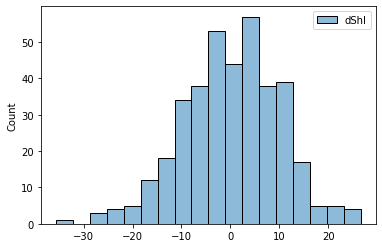

In [3]:
transect_name = 'aus0206-0005'
raw_shl_data = load_shoreline_data(transect_name=transect_name)
raw_wave_data = load_wave_data(transect_name=transect_name)
shl_data = generate_storm_dataset(raw_shl_data, raw_wave_data)

# Check with a plot
diff_shl_data = raw_shl_data.diff()
diff_shl_data.columns = ['dShl'] 
sns.histplot(diff_shl_data.dropna())
None

## Convert to storm dataset

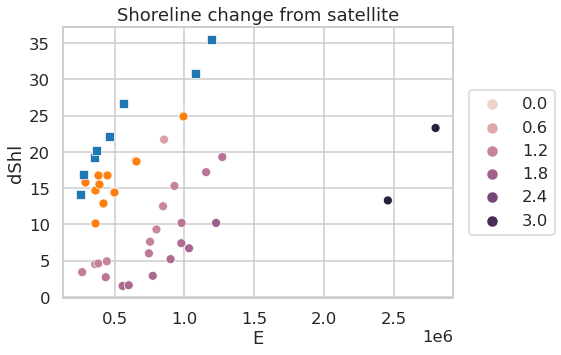

In [6]:
paretoThresh = 0.75
timeThresh = 100
eThresh = 0.25e6

plotData = shl_data.dropna().copy()
# some basic reduction of clearly dodgy data
cleanBool = (plotData['E']>eThresh)&(plotData['dShl']>1)&(plotData['timeDelta']<timeThresh)
plotData = plotData.loc[cleanBool,:]
# get the pareto front
plotData = find_pareto_front(plotData)
# now clean based on pareto distance
cleanData = plotData.loc[plotData['paretoDistance']<paretoThresh,:].copy()
x, y = cleanData['E'].values, cleanData['dShl'].values

x_log = np.log(x)
y_log = np.log(y)

log_scale=False
plot_pareto_points(plotData,pareto_thresh=paretoThresh)
None

## Fit a Bayesian Linear Regression in logspace - MAP

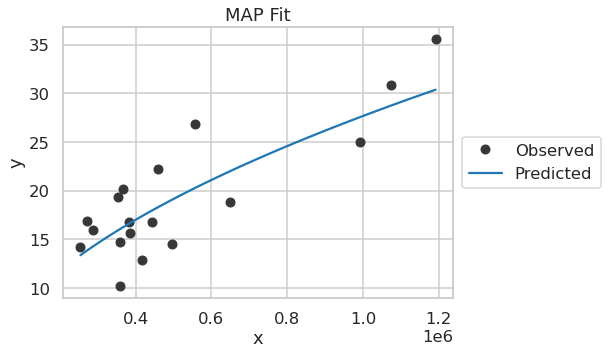

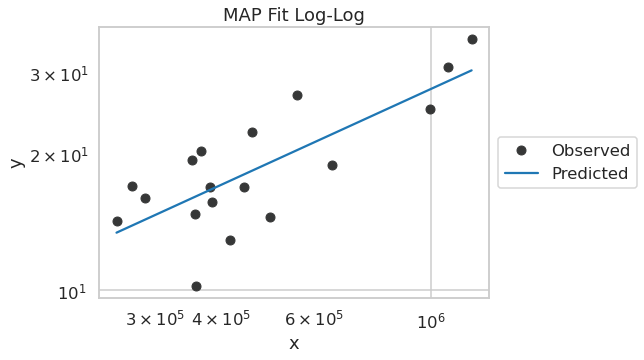

In [7]:
# fit a linear model to the data
model = lm.LinearRegression()
model.fit(x_log.reshape(-1,1),y_log)

sample_x = np.linspace(x.min(),x.max(),101)

y_pred = model.predict(np.log(sample_x).reshape(-1,1))

draw_fit(x,y,sample_x,np.exp(y_pred),title='MAP Fit')

draw_fit(x,y,sample_x,np.exp(y_pred),log_scale=True,title='MAP Fit Log-Log')
None

## Fit with numpryo

In [8]:
def linear_model(energy=None,dshl=None):
    '''
    Define linear model with priors for the parameters and model error
    Need to check that the assumptions for priors give the right posterior
    '''
    # Define priors
    coeff1 = numpyro.sample("coeff1",dist.Gamma(0.5, 0.25))
    intercept = numpyro.sample("intercept",dist.Normal(0, 2))
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    mu_out = coeff1 * energy + intercept
    dshl_modelled = numpyro.sample("dshl_modelled", dist.Normal(mu_out, sigma), obs=dshl)

In [9]:
# settings 
num_samples = 10000
burnin = int(0.25 * num_samples)
ci = 0.95

# Random number generator - jax style
rng_key = random.PRNGKey(2022)
rng_key, rng_key_ = random.split(rng_key)

# define the sampler
kernel = NUTS(linear_model)

# define the mcmc wrapper
mcmc_obj = MCMC(kernel, num_warmup=burnin, num_samples=num_samples)

mcmc_obj.run(
    rng_key_, energy=x_log, dshl=y_log
)
mcmc_obj.print_summary()
samples = mcmc_obj.get_samples()

sample: 100%|██████████| 12500/12500 [00:14<00:00, 833.59it/s, 79 steps of size 2.90e-02. acc. prob=0.85]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     coeff1      0.40      0.10      0.40      0.24      0.58   1436.45      1.00
  intercept     -2.27      1.33     -2.32     -4.58     -0.23   1447.17      1.00
      sigma      0.23      0.05      0.23      0.15      0.30   1325.09      1.00

Number of divergences: 53


In [10]:
posterior_predictive = Predictive(linear_model, samples)(
    rng_key_, energy=x_log)

# predictions =  posterior_predictive(rng_key_, energy=x_log)["dshl_modelled"]
prior = Predictive(linear_model, num_samples=10)(
    rng_key_, energy=x_log #, dshl=y_log
)

prior_mu = (
    jnp.expand_dims(prior["intercept"], -1)
    + jnp.expand_dims(prior["coeff1"], -1) * x_log
)

numpyro_data = az.from_numpyro(
    mcmc_obj,
    prior=prior,
    posterior_predictive=posterior_predictive,
    # coords={"school": np.arange(eight_school_data["J"])},
    # dims={"theta": ["school"]},
)
numpyro_data
# az.plot_trace(numpyro_data,figsize=(10,7))
# None

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

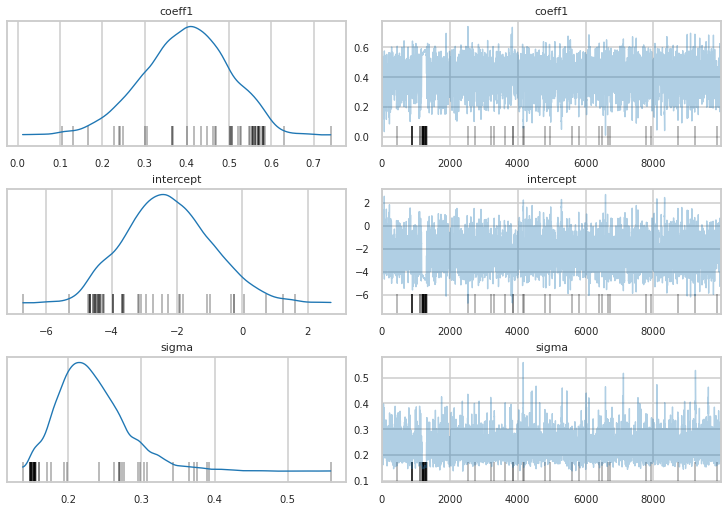

In [11]:
aa = az.plot_trace(numpyro_data,figsize=(10,7))


In [ ]:
posterior_predictive['dshl_modelled'].shape

Text(0.5, 1.0, 'prior')

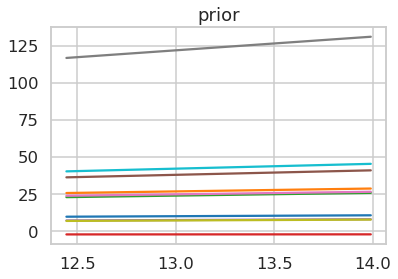

In [12]:
plt.plot(
    np.tile(x_log,(prior_mu.shape[0],1)).T,
    prior_mu.T
)
plt.title('prior')

Text(0.5, 1.0, 'Posterior')

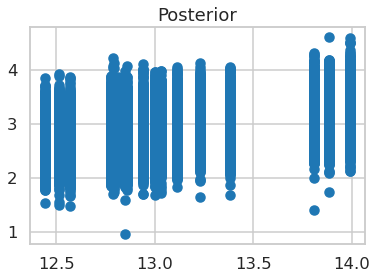

In [13]:
plt.scatter(
    np.tile(x_log,(posterior_predictive['dshl_modelled'].shape[0],1)),
    posterior_predictive['dshl_modelled']
)
plt.title('Posterior')

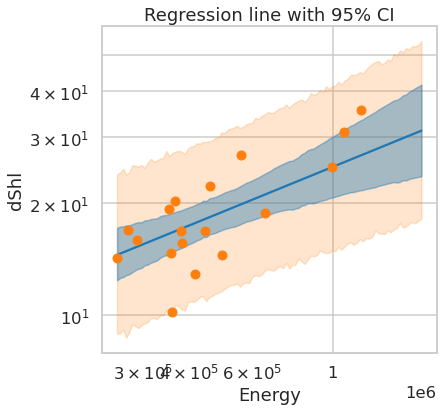

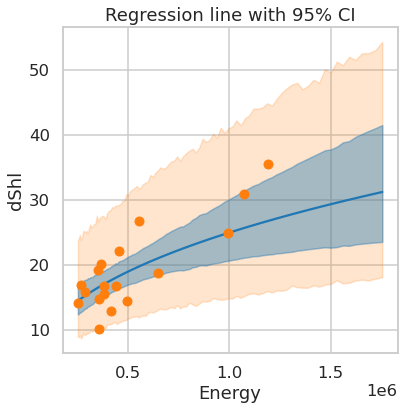

In [14]:
x_log_out = np.linspace(x_log.min(),x_log.max()+(x_log.max()-x_log.min())*0.25,100)

# Compute empirical posterior distribution over mu
posterior_mu = (
    jnp.expand_dims(samples["intercept"], -1)
    + jnp.expand_dims(samples["coeff1"], -1) * x_log_out
)

sim_y = Predictive(linear_model, samples)(
    rng_key_, energy=x_log_out)['dshl_modelled']

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, ci)
hpdi_sim_y = hpdi(sim_y, ci)

ax = plot_regression(np.exp(x_log), np.exp(y_log), np.exp(x_log_out), np.exp(mean_mu), np.exp(hpdi_mu), np.exp(hpdi_sim_y), log_scale=True)
ax.set(
    xlabel="Energy", ylabel="dShl", title="Regression line with 95% CI"
)
ax = plot_regression(np.exp(x_log), np.exp(y_log), np.exp(x_log_out), np.exp(mean_mu), np.exp(hpdi_mu), np.exp(hpdi_sim_y))
ax.set(
    xlabel="Energy", ylabel="dShl", title="Regression line with 95% CI"
)
None